In [ ]:
# ! wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [29]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

In [22]:
df = pd.read_csv("housing.csv")

<Axes: ylabel='Density'>

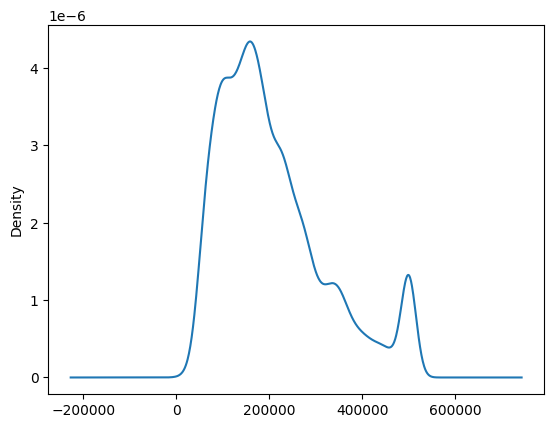

In [4]:
df.median_house_value.plot(kind='kde')

In [23]:
cols_to_leave = ['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value']
df1 = df[df.ocean_proximity.isin(['<1H OCEAN', 'INLAND'])][cols_to_leave]

## Question 1

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
df1.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

## Question 2

In [8]:
df1.population.median()

1195.0

In [62]:
np.random.seed(42)

n = len(df1)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df1.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [63]:
y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [64]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [65]:
def prepare_X(df, fillna=0):
    df_num = df.fillna(fillna)
    X = df_num.values
    return X
mean_train = df_train.total_bedrooms.mean()

In [66]:
# fill 0
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [67]:
rmse(y_train, y_pred)

0.042843176172459516

In [68]:
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
rmse(y_val, y_pred)

0.04249252768561647

In [69]:
# fill mean
X_train = prepare_X(df_train, fillna=mean_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [70]:
rmse(y_train, y_pred)

0.042843223032394684

In [71]:
X_val = prepare_X(df_val,fillna=mean_train)
y_pred = w_0 + X_val.dot(w)
rmse(y_val, y_pred)

0.04249113635359535

## Question 3

both are good

In [73]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [76]:
X_train = prepare_X(df_train)

for reg in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
  w_0, w = train_linear_regression_reg(X_train, y_train, r=reg)

  y_pred = w_0 + X_train.dot(w)
  X_val = prepare_X(df_val,fillna=mean_train)
  y_pred = w_0 + X_val.dot(w)
  print(reg, rmse(y_val, y_pred))

0 0.04249221934001521
1e-06 0.04249221964966912
0.0001 0.04249225049162035
0.001 0.042492545570400164
0.01 0.04249689248653913
0.1 0.04263448771496076
1 0.0443451224166551
5 0.045768895784816535
10 0.04605744408268204


## Question 4

0

In [86]:
rmse_list = []

for r in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:

    idx = np.arange(n)
    np.random.seed(r)
    np.random.shuffle(idx)

    df_shuffled = df1.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train_orig = df_train.median_house_value.values
    y_val_orig = df_val.median_house_value.values
    y_test_orig = df_test.median_house_value.values

    y_train = np.log1p(y_train_orig)
    y_val = np.log1p(y_val_orig)
    y_test = np.log1p(y_test_orig)

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']

    X_null_train = prepare_X(df_train, fillna=0)
    w_0, w = train_linear_regression(X_null_train, y_train)

    X_null_val = prepare_X(df_val, fillna=0)
    y_null_reg_val = w_0 + X_null_val.dot(w)
    rmse_val = rmse(y_val, y_null_reg_val)

    rmse_list.append(rmse_val)

    print(r, w_0, rmse_val)

0 2.579268318362648 0.043078423877087005
1 2.4657167723231983 0.04238166915988499
2 2.5481522819126354 0.04245198772609361
3 2.542492513386702 0.04247505712412474
4 2.5270677464999745 0.04215621011537387
5 2.544726071263632 0.04239050308401198
6 2.5439633835296727 0.043265645001332044
7 2.503516890433301 0.041711978630933025
8 2.612360508688119 0.04281595630160277
9 2.608121165258477 0.0429157589155753


In [87]:
rmse_list

[0.043078423877087005,
 0.04238166915988499,
 0.04245198772609361,
 0.04247505712412474,
 0.04215621011537387,
 0.04239050308401198,
 0.043265645001332044,
 0.041711978630933025,
 0.04281595630160277,
 0.0429157589155753]

In [90]:
np.std(rmse_list)

0.0004381996384509626

## Question 5

0.005

In [92]:
r = 9

idx = np.arange(n)
np.random.seed(r)
np.random.shuffle(idx)

df_shuffled = df1.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

frames = [df_train, df_val]
df_train_val = pd.concat(frames)

df_train_val = df_train_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train_val_orig = df_train_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train_val = np.log1p(y_train_val_orig)
y_test = np.log1p(y_test_orig)

del df_train_val['median_house_value']
del df_test['median_house_value']

In [94]:
X_null_train_val = prepare_X(df_train_val, fillna=0)
w_0_train_val, w_train_val = train_linear_regression_reg(X_null_train_val, y_train_val, r=0.001)

X_null_test = prepare_X(df_test, fillna=0)
y_null_pred_test = w_0_train_val + X_null_test.dot(w_train_val)

np.round(rmse(y_test, y_null_pred_test),2)

0.04

## Question 6

0.35